

**RGB-T FEATURE FUSION**


> Multi-model (rgb,thermal), multi-scale and multi-level feature fusion technique to generate state-of-the-art segmentation results. Inputs for the network is aligned thermal and rgb[link text](https://) images along with the ground-truth for which network is supposed to trained.



In [ ]:
##LOADING PACKAGES
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D
import os
# from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras.models import Model
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate,MaxPool2D

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.utils import normalize


print(os.listdir("../data2/"))

2022-04-08 20:52:37.192789: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


['thermal', 'RGB', 'GT', '.ipynb_checkpoints']


In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Model
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import  GlobalAveragePooling2D
from tensorflow.image import ResizeMethod

import T,R ##Our thermal and rgb files for respective vgg16 network

**WORKING ON 3 CHANNEL IMAGE WITH DIMENSION 352 X 352**

In [ ]:

SIZE_X = 352
SIZE_Y = 352
IMG_SIZE = 352
input_shape=(SIZE_X, SIZE_Y, 3)

**Complementary Weight (CW)**  module is used to  adaptively fuse important multi-modality information by learning the content-dependent weight vectors from RGB and thermal images.

In [ ]:
####CW----ATTENTION
def attention(input_r,input_t,name=""):

    con_temp=concatenate([input_r,input_t], axis=3)

    attention1_=Conv2D(filters=128,kernel_size=(3,3),padding="same", name="attention_1_"+name, activation="relu")(con_temp)
    attention2_=Conv2D(filters=2,kernel_size=(3,3),padding="same", name="attention_2_"+name, activation="softmax")(attention1_)
    weight=attention2_ #tf.keras.activations.softmax(attention2_)
    w_r, w_t = tf.split(weight, 2, 3)
    return w_r, w_t

Global_attention_layer() implementing the task of Squeeze and Excitaiton Network **(SENet)**

In [ ]:
def global_attention_layer(input_x, name=None):
     squeeze = tf.math.reduce_mean(input_x, [1, 2], name='squeeze', keepdims=True)
     ga=Conv2D(filters=128, kernel_size=(1,1),padding="same", activation="sigmoid", use_bias=True,name=name+"_ga")(squeeze)
     return ga 

In [ ]:
vgg_t= T.Model_t()  #### LOADING THERMAL MODEL
vgg_t.build_model() #### BUILDING 
vgg_r= R.Model_r() ##### LOADING RGB MODEL
vgg_r.build_model() #### BUILDING


T.py called--Model created
R.py called--Model created


In [ ]:
w1, w2 = attention(vgg_r.rconv2_5_, vgg_t.tconv2_5_,"fusion_conv2") ##EXTRACTING THE WEITAGE GIVEN BY CW
fusion_conv2 = tf.math.add(w1*vgg_r.rconv2_5_, w2*vgg_t.tconv2_5_)  ## USING EXTRACTED WEITAGE TO FUSE RGB AND THERMAL DATA TO PRODUCE RGB-T

In [ ]:
 _conv2 = fusion_conv2    #CW1---F1 (feature map 1)
print(w1.shape,vgg_r.rconv2_5_.shape,vgg_r.rconv3_6_.shape,vgg_r.conv6_6.shape)

(?, 176, 176, 1) (?, 176, 176, 128) (?, 88, 88, 128) (?, 44, 44, 128)


In [ ]:
w3, w4 = attention(vgg_r.rconv3_6_, vgg_t.tconv3_6_, name= 'fusion_conv3') ##EXTRACTING THE WEITAGE GIVEN BY CW

fusion_conv3 = tf.math.add((w3*vgg_r.rconv3_6_), (w4*vgg_t.tconv3_6_))


In [ ]:
F2=_conv2

In [ ]:
_conv3 = fusion_conv3 # CW2-F3
F3=_conv3
print(_conv3.shape)

(?, 88, 88, 128)


In [ ]:
w_r, w_t = attention(vgg_r.conv6_6, vgg_t.conv6_6,'fusion_conv5') ##EXTRACTING THE WEITAGE GIVEN BY CW

In [ ]:
print(w_r.shape)
print(w_t.shape)
print(vgg_r.conv6_6.shape,vgg_t.conv6_6.shape)

(?, 44, 44, 1)
(?, 44, 44, 1)
(?, 44, 44, 128) (?, 44, 44, 128)


In [ ]:
h_fusion = tf.math.add(w_r*vgg_r.conv6_6,w_t*vgg_t.conv6_6) # CW--F5 


AT THE OUTPU LAYER, 3 FEATURE MAPS WILL BE USED TO CALCULATE THE SCORE. ALL FEATURE MAPS GIVEN EQUAL WEITAGE AND LAST SCORE FEATURE MAP WILL BE CONSIDERED AS A FINAL OUTPUT.

In [ ]:

score_3=Conv2D(filters=1,kernel_size=(1,1),padding="same", name="Score_3", activation='sigmoid')(vgg_r.conv6_6) 
score_t=Conv2D(filters=1,kernel_size=(1,1),padding="same", name="Score_t", activation='sigmoid')(vgg_t.conv6_6)



In [ ]:
F5=h_fusion
F5_global_pool=global_attention_layer(F5,"F5_SW_")

2022-04-08 20:52:42.220545: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-08 20:52:42.256051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA A100-SXM4-40GB MIG 2g.10gb major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:87:00.0
2022-04-08 20:52:42.256075: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-08 20:52:42.259773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-08 20:52:42.261571: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-04-08 20:52:42.261786: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-04-08 20:52:42.262233: I tensorflow/stream_executor

In [ ]:
from tensorflow.keras.layers import Multiply


In [ ]:
F5.shape

TensorShape([Dimension(None), Dimension(44), Dimension(44), Dimension(128)])

In [ ]:
F3_temp=Multiply()([F3,F5_global_pool])


In [ ]:
from tensorflow.keras.layers import UpSampling2D,Add
F5_upsample2=UpSampling2D(size=(2,2),interpolation='bilinear')(F5)

In [ ]:
print(F5_upsample2.shape, F3_temp.shape,F5.shape)

(?, 88, 88, 128) (?, 88, 88, 128) (?, 44, 44, 128)


In [ ]:
F6=Add()([F5_upsample2,F3_temp])
F6.shape

###CORRECT SO FAR

TensorShape([Dimension(None), Dimension(88), Dimension(88), Dimension(128)])

**BILINEAR INTERPOLATION** IS USED WHILE DOING THE UPSCALING

In [ ]:
# F2_temp=Multiply()([F5_global_pool,_conv2])
S1=Conv2D(filters=1,kernel_size=(1,1),padding="same",name="S1_inner", activation='sigmoid')(F5)
S2=Conv2D(filters=1,kernel_size=(1,1),padding="same", name="S2_inner",activation='sigmoid')(F6)


In [ ]:
F2_temp=global_attention_layer(F2,"F2_SW_")

In [ ]:
F5_upsample4=UpSampling2D(size=(4,4),interpolation='bilinear')(F5)
F6_upsample2=UpSampling2D(size=(2,2),interpolation='bilinear')(F6)

F7=Add()([F2_temp,F5_upsample4,F6_upsample2])

In [ ]:
S3_temp=UpSampling2D(size=(2,2),interpolation='bilinear')(F7)
S3=Conv2D(filters=1,kernel_size=(1,1),padding="same",  name="S3", activation='sigmoid')(S3_temp)


In [ ]:
# S3=UpSampling2D(size=(2,2))(S3)
S2=UpSampling2D(size=(4,4),interpolation='bilinear',name="S2")(S2)
S1=UpSampling2D(size=(8,8),interpolation='bilinear', name="S1")(S1)

In [ ]:
print(S3.shape,S2.shape,S1.shape)

(?, 352, 352, 1) (?, 352, 352, 1) (?, 352, 352, 1)


**EVALUATION MATRICES**
**LOSS:** MEAN ABSOLUTE EROOR 
**SCORE:** F_BETA SCORE where (BETA)^2=0.3

In [ ]:
####### EVALUATION MATRICES ###########

def recall_m(y_true, y_pred): ##RECALL
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred): ##PRECISION
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f_beta(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 1.3*((precision*recall)/(0.3*precision+recall+K.epsilon()))

def MAE_loss(imageA, imageB):
    mae = K.sum(K.abs(imageB - imageA))
    mae = mae / (SIZE_X*SIZE_Y)
    return mae


**Optimizer:** Adam

---


**Learning Rage:** 1e-5

---


**Score maps S1,S2,S3 weitage:** 1,1,1 (equal)

---


**Loss:**Binary crossentropy


In [ ]:
opt = tf.keras.optimizers.Adam(1e-5)
model=Model(inputs=[vgg_r.Input_r,vgg_t.Input_t], outputs=[S3,S2,S1])
model.compile(optimizer=opt, loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy'],
              loss_weights=[1,1,1],metrics=[f_beta,MAE_loss,precision_m, recall_m])
# model.summary()

Train and test data is stored uising train-test.py file which will do augmentation also. Data is normalized in 0 to 1 range by dividing it by 255.

In [ ]:
X_train=np.load("label_split_data/X_train.npy")
X_test=np.load("label_split_data/X_test.npy")
X_train_t=np.load("label_split_data/X_train_t.npy")
X_test_t=np.load("label_split_data/X_test_t.npy")
y_train=np.load("label_split_data/y_train.npy")
y_test=np.load("label_split_data/y_test.npy")
y_test_label=np.load("label_split_data/y_test_label.npy")
y_train_label=np.load("label_split_data/y_train_label.npy")

X_test=X_test/255.
X_test_t=X_test_t/255.
X_train_t=X_train_t/255.
X_train=X_train/255.

y_train=((y_train>50)*255)/255.
y_test=((y_test>50)*255)/255.

In [ ]:
# model.save("../Digital-SC_dataset2_final_segmentation/model/RGBT-30dec_epochs.h5")  ##to store trained model
# model.load_weights("../Digital-SC_dataset2_final_segmentation/model/RGBT-30dec_epochs.h5")  ## to load trained model

In [ ]:
model.evaluate([X_test,X_test_t],[y_test,y_test,y_test],batch_size=1,verbose=1) ##EVALUATE THE TRAINED MODEL

2022-04-08 20:53:44.102703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-04-08 20:53:45.519398: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


46/46 [==============================] - 12s 259ms/sample - loss: 0.8894 - S3_loss: 0.2962 - S2_loss: 0.3050 - S1_loss: 0.2883 - S3_f_beta: 0.4500 - S3_MAE_loss: 0.0646 - S3_precision_m: 0.5162 - S3_recall_m: 0.4733 - S2_f_beta: 0.4531 - S2_MAE_loss: 0.0651 - S2_precision_m: 0.5127 - S2_recall_m: 0.4847 - S1_f_beta: 0.4411 - S1_MAE_loss: 0.0664 - S1_precision_m: 0.5026 - S1_recall_m: 0.4658


[0.8894205438782987,
 0.2961731,
 0.30499673,
 0.28825083,
 0.4499679,
 0.06463935,
 0.51618594,
 0.47327754,
 0.45305833,
 0.065135285,
 0.51274455,
 0.4847302,
 0.44108543,
 0.066444114,
 0.5026205,
 0.46576646]

In [ ]:
# %%capture output
history= model.fit([X_train,X_train_t], [y_train,y_train,y_train],
                    batch_size = 1,
                    verbose=1, 
                    epochs=1,
                    validation_data=([X_test,X_test_t], [y_test,y_test,y_test]),
                    shuffle=True)

Train on 5152 samples, validate on 46 samples
  27/5152 [..............................] - ETA: 52:14 - loss: 0.9007 - S3_loss: 0.2974 - S2_loss: 0.3094 - S1_loss: 0.2939 - S3_f_beta: 0.4036 - S3_MAE_loss: 0.0851 - S3_precision_m: 0.4579 - S3_recall_m: 0.5163 - S2_f_beta: 0.4047 - S2_MAE_loss: 0.0851 - S2_precision_m: 0.4563 - S2_recall_m: 0.5283 - S1_f_beta: 0.3916 - S1_MAE_loss: 0.0859 - S1_precision_m: 0.4405 - S1_recall_m: 0.5093

In [ ]:
# model.load_weights("model/out_dataset_before_gt_correction_rgbt_SOTA.h5")

Training model for 20 epochs and batch size of 1. It is trained on NVIDIA DGX SERVER 10gb GPU container. Model took about 40 epochs to converge in end to end training.

In [ ]:
%%capture output
history= model.fit([X_train,X_train_t], [y_train,y_train,y_train],
                    batch_size = 1,
                    verbose=2, 
                    epochs=40,
                    validation_data=([X_test,X_test_t], [y_test,y_test,y_test]),
                    shuffle=True)

In [ ]:
output.show() #STORED OUTPUT 

Train on 5152 samples, validate on 46 samples
Epoch 1/40
5152/5152 - 722s - loss: 0.2132 - S3_loss: 0.0659 - S2_loss: 0.0661 - S1_loss: 0.0812 - S3_f_beta: 0.6355 - S3_MAE_loss: 0.0369 - S3_precision_m: 0.6753 - S3_recall_m: 0.6173 - S2_f_beta: 0.6308 - S2_MAE_loss: 0.0365 - S2_precision_m: 0.6714 - S2_recall_m: 0.6146 - S1_f_beta: 0.5467 - S1_MAE_loss: 0.0472 - S1_precision_m: 0.6122 - S1_recall_m: 0.4992 - val_loss: 0.5027 - val_S3_loss: 0.1593 - val_S2_loss: 0.1643 - val_S1_loss: 0.1791 - val_S3_f_beta: 0.6923 - val_S3_MAE_loss: 0.0405 - val_S3_precision_m: 0.7634 - val_S3_recall_m: 0.6408 - val_S2_f_beta: 0.6852 - val_S2_MAE_loss: 0.0409 - val_S2_precision_m: 0.7590 - val_S2_recall_m: 0.6357 - val_S1_f_beta: 0.5968 - val_S1_MAE_loss: 0.0467 - val_S1_precision_m: 0.6622 - val_S1_recall_m: 0.5357
Epoch 2/40
5152/5152 - 721s - loss: 0.1036 - S3_loss: 0.0309 - S2_loss: 0.0312 - S1_loss: 0.0415 - S3_f_beta: 0.7561 - S3_MAE_loss: 0.0177 - S3_precision_m: 0.7895 - S3_recall_m: 0.7366 - S2

In [ ]:
model.save("model_segmentation/rgbt_sota.h5")

In [ ]:
np.save("history/rgbt_sota_fisrt30.npy",model.history.history)

In [ ]:
model.load_weights("../Digital-SC_dataset2_final_segmentation/model/RGBT-30dec_epochs.h5")
# model.save("model/RGBT-30dec_epochs.h5")

In [ ]:
model.history.history['val_S3_f_beta']

[0.69227946,
 0.72050536,
 0.71683294,
 0.71544874,
 0.73748964,
 0.7297811,
 0.7490991,
 0.7454535,
 0.737418,
 0.6958413,
 0.7457176,
 0.7417246,
 0.7475983,
 0.7321316,
 0.73764503,
 0.74221677,
 0.74577826,
 0.7354605,
 0.73969483,
 0.7396557,
 0.7447304,
 0.74101573,
 0.73725516,
 0.71921283,
 0.7307924,
 0.7128712,
 0.732514,
 0.7331488,
 0.73228985,
 0.7290999,
 0.72748095,
 0.7278191,
 0.73459435,
 0.73236257,
 0.7340859,
 0.7172246,
 0.7236245,
 0.72140974,
 0.72033036,
 0.7273417]

In [ ]:

x=np.load("history/RGB-T_30dec.npy",allow_pickle=True).item()

**TRAINING VS TESTING RESULTS**

In [ ]:
# for k in x.items():
#     print(k)
print("-----TRAINING-------")
print("Epoch\t","S3_f_beta\t","S3_MAE_loss\t","S3_precision\t","S3_recall")
for i in range(len(x['S1_f_beta'])):
               print(i+1,"\t",x['S3_f_beta'][i],"\t",x['S3_MAE_loss'][i],"\t\t",
                     x['S3_precision_m'][i],"\t",x['S3_recall_m'][i])

print("\n\n\n-------TESTING--------")
print("Epoch\t","val_S3_f_beta\t","val_S3_MAE_loss\t","val_S3_precision\t","val_S3_recall")
for i in range(len(x['val_S1_f_beta'])):
               print(i+1,"\t",x['val_S3_f_beta'][i],"\t",x['val_S3_MAE_loss'][i],"\t\t",
                     x['val_S3_precision_m'][i],"\t",x['val_S3_recall_m'][i])


-----TRAINING-------
Epoch	 S3_f_beta	 S3_MAE_loss	 S3_precision	 S3_recall
1 	 0.4802107 	 0.1598367 		 0.5602332 	 0.45337328
2 	 0.68987435 	 0.10647716 		 0.74419856 	 0.6739866
3 	 0.73877275 	 0.08811276 		 0.78017235 	 0.73181707
4 	 0.78353107 	 0.07410758 		 0.81415474 	 0.7808768
5 	 0.82708806 	 0.05820982 		 0.8471573 	 0.8310455
6 	 0.8535553 	 0.047655966 		 0.867443 	 0.85872316
7 	 0.8732011 	 0.040468477 		 0.8832335 	 0.8782527
8 	 0.88594633 	 0.035938885 		 0.89511263 	 0.88853484
9 	 0.89749426 	 0.031957284 		 0.9054075 	 0.89845693
10 	 0.90754896 	 0.028697135 		 0.9141073 	 0.9066245
11 	 0.9155567 	 0.026190473 		 0.92134416 	 0.9140599
12 	 0.9217158 	 0.024266 		 0.92789996 	 0.9188701
13 	 0.9273439 	 0.022525892 		 0.9328387 	 0.9239742
14 	 0.93179166 	 0.021269837 		 0.9366076 	 0.92833984
15 	 0.93661654 	 0.019501908 		 0.94074166 	 0.9331451
16 	 0.9398568 	 0.018124448 		 0.9436368 	 0.9364214
17 	 0.9435836 	 0.016784059 		 0.9466017 	 0.9406399
18 

**OUTPUT IMAGE (SEMANTIC SEGMENTED)  GENERATED ON TEST RGB-THERMAL INPUT**

3


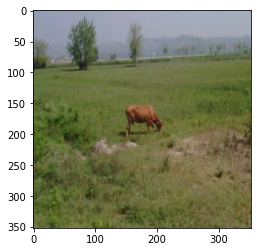

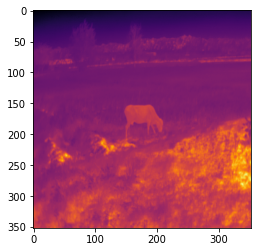

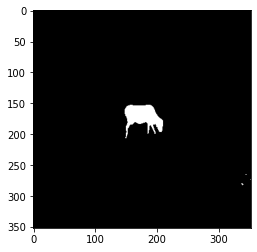

######PRIDICTED#######


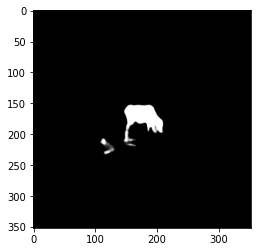

Obtained threshold:  121.0


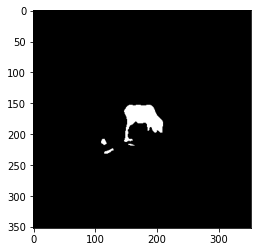

In [ ]:
import random

index=random.randint(0,len(X_test))
# index=350
img=X_test[index]
mask=y_test[index]
img_t=X_test_t[index]
print(index)


import matplotlib.pyplot as plt
plt.imshow(img)
plt.show();
plt.imshow(img_t)
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()

# x_input=[img
print("######PRIDICTED#######")
x=np.array([img])
x_t=np.array([img_t])
y_output=model.predict([x,x_t])
# plt.imshow(y_output[0],cmap='gray')

# temp=y_output[0]>=0.45
plt.imshow(y_output[0][0],cmap='gray')
plt.show()

saliencyMap = (y_output[0][0] * 255).astype("uint8")
otsu_threshold, image_result = cv2.threshold(saliencyMap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Obtained threshold: ", otsu_threshold)
plt.imshow(image_result,cmap='gray')
plt.show()
# plt.imsave("graphs/b200_2otsu.png",image_result,cmap='gray')